In [3]:
%pip install xgboost --break-system-package

Note: you may need to restart the kernel to use updated packages.


Index(['FlightDate', 'Reporting_Airline', 'OriginAirportSeqID', 'OriginState',
       'DepDelayMinutes', 'Cancelled', 'CancellationCode', 'Diverted',
       'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay',
       'LateAircraftDelay'],
      dtype='object')


/var/folders/cr/rmz3xz_s61dd6zjh0mqy_z2m0000gn/T/ipykernel_63350/920970224.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['FlightDate'] = pd.to_datetime(df['FlightDate'])


Random Forest MAE: 4.211178333193185, RMSE: 10.296798016271717
XGBoost MAE: 4.791396796956854, RMSE: 12.379932647251032


/Users/akshatsharma/CS506/CS506-Final-Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/akshatsharma/CS506/CS506-Final-Project/.venv/lib/python3.13/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


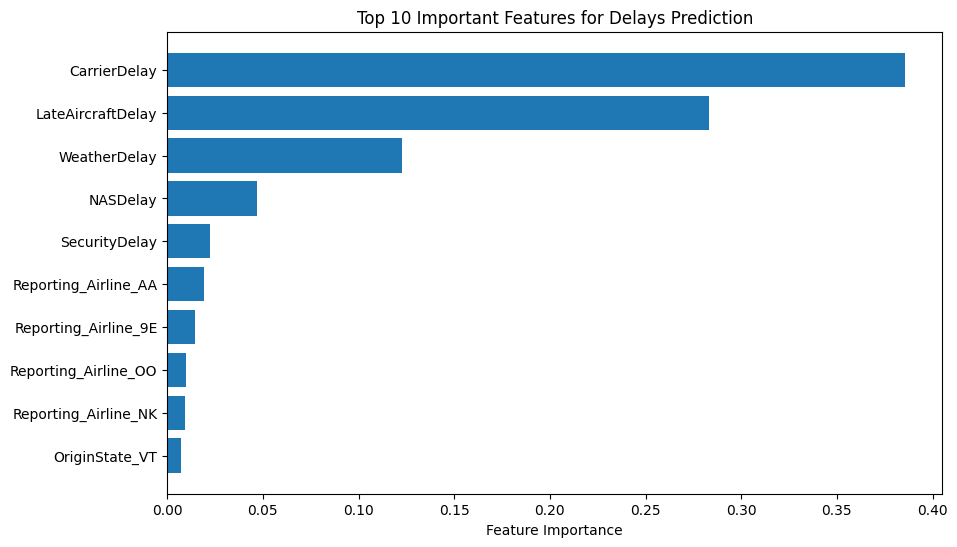

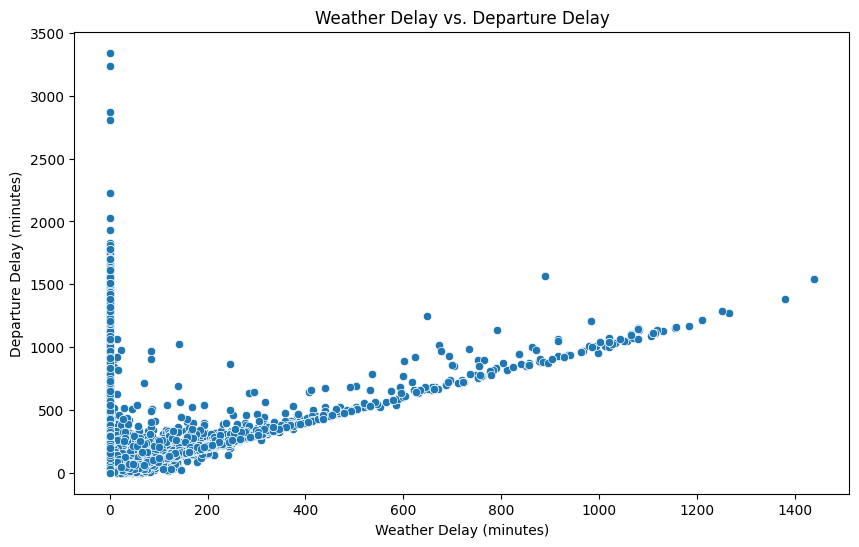

In [4]:
import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Load Data
all_files = glob.glob("data/*.csv")
df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
print(df.columns)

# Step 2: Preprocessing
# Check which columns are actually present in the dataset
available_columns = df.columns.tolist()

# Fill missing delay columns with 0 (only for columns that exist)
delay_columns = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for col in delay_columns:
    if col in available_columns:
        df[col] = df[col].fillna(0)

# Convert FlightDate to datetime and extract features (if FlightDate exists)
if 'FlightDate' in available_columns:
    df['FlightDate'] = pd.to_datetime(df['FlightDate'])
    df['Day'] = df['FlightDate'].dt.day
    df['Month'] = df['FlightDate'].dt.month
    df['Year'] = df['FlightDate'].dt.year

# One-hot encoding for categorical features (only for columns that exist)
categorical_columns = ['Reporting_Airline', 'OriginState']
for col in categorical_columns:
    if col in available_columns:
        df = pd.get_dummies(df, columns=[col])

# Define the target variable and features
target_column = 'DepDelayMinutes'
if target_column not in available_columns:
    raise ValueError(f"Target column '{target_column}' not found in the dataset")

columns_to_drop = ['FlightDate', 'Cancelled', 'Diverted', 'CancellationCode']
X = df.drop(columns=[col for col in columns_to_drop if col in available_columns] + [target_column])
y = df[target_column]

# Remove any rows with NaN values in the target variable
mask = y.notna()
X = X[mask]
y = y[mask]

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Model Training
# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

# XGBoost Regressor
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Step 5: Evaluation
rf_mae = mean_absolute_error(y_test, rf_preds)
rf_rmse = mean_squared_error(y_test, rf_preds, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
xgb_rmse = mean_squared_error(y_test, xgb_preds, squared=False)

print(f"Random Forest MAE: {rf_mae}, RMSE: {rf_rmse}")
print(f"XGBoost MAE: {xgb_mae}, RMSE: {xgb_rmse}")

# Feature Importance for XGBoost
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features for Delays Prediction")
plt.show()

# Visualization
if 'WeatherDelay' in available_columns and target_column in available_columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=df['WeatherDelay'], y=df[target_column])
    plt.xlabel('Weather Delay (minutes)')
    plt.ylabel('Departure Delay (minutes)')
    plt.title('Weather Delay vs. Departure Delay')
    plt.show()
else:
    print("Unable to create scatter plot: required columns not found in the dataset")

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. Hyperparameter Tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf_grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rf_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
rf_grid_search.fit(X_train, y_train)
best_rf_model = rf_grid_search.best_estimator_

# 2. Hyperparameter Tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}
xgb_grid_search = GridSearchCV(
    estimator=XGBRegressor(random_state=42, eval_metric='rmse'),
    param_grid=xgb_param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
xgb_grid_search.fit(X_train, y_train)
best_xgb_model = xgb_grid_search.best_estimator_

# 3. Retrain with Best Models
rf_best_preds = best_rf_model.predict(X_test)
xgb_best_preds = best_xgb_model.predict(X_test)

# 4. Evaluation
rf_best_mae = mean_absolute_error(y_test, rf_best_preds)
rf_best_rmse = mean_squared_error(y_test, rf_best_preds, squared=False)
xgb_best_mae = mean_absolute_error(y_test, xgb_best_preds)
xgb_best_rmse = mean_squared_error(y_test, xgb_best_preds, squared=False)

# Print evaluation results for optimized models
rf_grid_search_results = f"Optimized Random Forest - MAE: {rf_best_mae}, RMSE: {rf_best_rmse}"
xgb_grid_search_results = f"Optimized XGBoost - MAE: {xgb_best_mae}, RMSE: {xgb_best_rmse}"

print(rf_grid_search_results)
print(xgb_grid_search_results)

# 5. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# 6. Delay Trends Over Time (if time-based features are available)
if 'Month' in df and target_column in df:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Month', y=target_column, ci=None)
    plt.xlabel("Month")
    plt.ylabel("Average Departure Delay (minutes)")
    plt.title("Average Departure Delay by Month")
    plt.show()